
# Setup

## Load packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from  tqdm import  tqdm
from scipy.special import binom
import itertools
import helpers as hp
import simulations as sims
import importlib
importlib.reload(sims)

plt.style.use('ggplot')

FIG_PATH = "./../../figures/"

## Load processed data

In [2]:
data= pd.read_csv('./../../experimental_data/processed_data/single_cell_data.csv')
data_avg = pd.read_csv('./../../experimental_data/processed_data/avg_data.csv')
data_avg_one_cell = pd.read_csv('./../../experimental_data/processed_data/avg_data_one_cell.csv')
fits = pd.read_csv('./output/fits_summary.csv')
fits['p'] = fits.beta_population.values/(2*fits.alpha_population.values)
experiments = data.experiment.unique()
experiments

array(['NR-SpCas9', 'CTG-Cpf1', 'CGG-Cpf1', 'NoGuideRNA',
       'GAA-SpCas9-comb', 'GAA - Cpf1', 'CTG-SpCas9-comb', 'CGG-SpCas9',
       'NR-Cpf1-comb'], dtype=object)

# Compute rate to turn green for data

In [39]:
def get_turn_green_rate(df):
    times = df.time.values
    bf_avg = df.bf.values
    gfp_avg = df.gfp.values
    dt = times[1:]-times[:-1]
    ng = bf_avg[:-1]-gfp_avg[:-1]
    dgdt = (gfp_avg[1:]-gfp_avg[:-1])/dt
    dndt = (bf_avg[1:]-bf_avg[:-1])/dt
    r = (dgdt-dndt*gfp_avg[:-1]/bf_avg[:-1])/ng
    return times[:-1],r

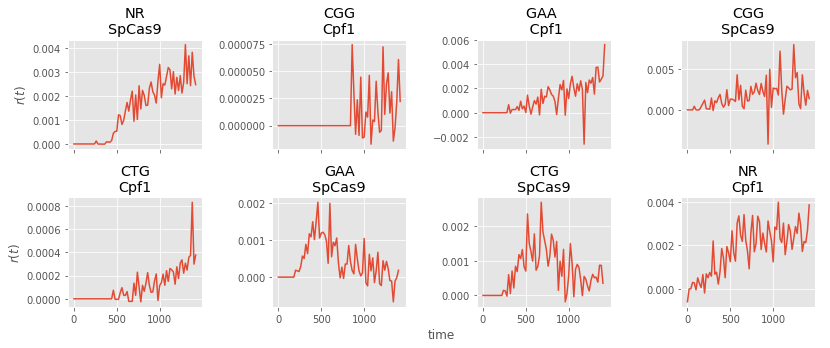

In [40]:
k=0
fig,axs = plt.subplots(ncols = 4,nrows=2,figsize=(12,5),sharey=False,sharex=True)
for exp in [e for e in experiments if e != "NoGuideRNA"]:
    df = data_avg[data_avg.experiment==exp]
    
    axs[k%2,k//2].set_title(data_avg[data_avg.experiment== exp].defect.values[0]\
                     +'\n'+data_avg[data_avg.experiment== exp].nuclease.values[0])
   
    t,r = get_turn_green_rate(df)
    alpha = fits[fits.experiment==exp].alpha_population.values[0]
    axs[k%2,k//2].plot(t,r,'-')
    
#     df = data_avg_one_cell[data_avg_one_cell.experiment==exp]
#     t,r = get_turn_green_rate(df)
#     axs[k%2,k//2].plot(t,r,label='two cell wells')
    
    k = k+1
#axs[0].legend(frameon=True)
axs[0,0].set_ylabel(r'$r(t)$')
axs[1,0].set_ylabel(r'$r(t)$')
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.grid(False)
plt.tight_layout()
plt.xlabel('time');
#plt.ylabel(r'$r(t)$');
plt.savefig(FIG_PATH+"r-vs-t_data.pdf",bbox_inches = "tight")

# Comparison to synthetic data

## Constant probability model

In [98]:
def f(gt,t,n,cell_type):
    return abs(np.random.normal(60,0.3*60))
#     if cell_type==0:
#         return abs(np.random.normal(60,0.3*60)) # kernel
#     else:
#         return abs(np.random.normal(30,0.3*30)) 
#f0 = lambda : np.random.exponential(200) # lag time distribution
f0 = lambda : abs(np.random.normal(100,0.2*100)) # lag time distribution

In [88]:
model = sims.constant_probability_model(f,f0,0.4)
df = model.run_ensemble(400,2000,tmax=5000,dt_sample=2)
times = df[df.well==df.well.unique()[0]].time.values
df_avg = df.groupby(['time']).mean()
df_avg['time'] = times

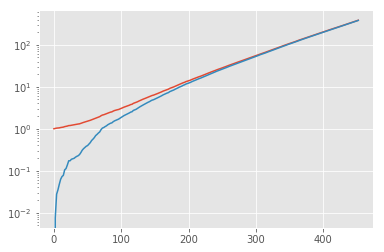

In [92]:
plt.plot(df_avg.time,df_avg.bf)
plt.semilogy(df_avg.time,df_avg.gfp)

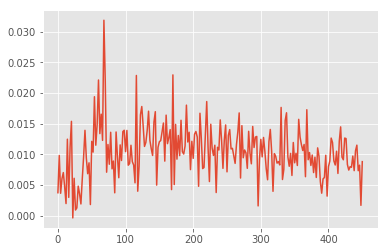

In [90]:
times = df_avg.time.values
bf_avg = df_avg.bf.values
gfp_avg = df_avg.gfp.values
dt = times[1:]-times[:-1]
   
ng = bf_avg[:-1]-gfp_avg[:-1]

dgdt = (gfp_avg[1:]-gfp_avg[:-1])/dt
dndt = (bf_avg[1:]-bf_avg[:-1])/dt


# subtract r2 times green cells per non-green from r1 to get rate to turn green 
r = dgdt-dndt*gfp_avg[:-1]/bf_avg[:-1]
#plt.plot(times[:-1],dndt*gfp_avg[:-1]/bf_avg[:-1])
plt.plot(times[:-1],r/ng)
#plt.plot(times,gfp_avg)

100%|██████████| 8/8 [00:38<00:00,  6.58s/it]


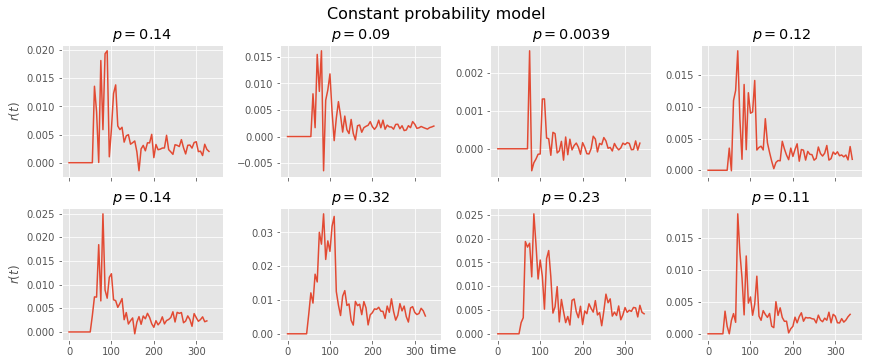

In [99]:
k=0
fig,axs = plt.subplots(ncols = 4,nrows=2,figsize=(12,5),sharey=False,sharex=True, constrained_layout=True)
for exp in tqdm([e for e in experiments if e != "NoGuideRNA"]):
    
    p = np.random.rand()*0.5 + 0.002 
    model = sims.constant_probability_model(f,f0,p)


    df = model.run_ensemble(170,200,tmax=500,dt_sample=5)
    
    axs[k%2,k//2].set_title(r"$p = {:.2}$".format(p))
    
    
    times = df[df.well==df.well.unique()[0]].time.values
    df = df.groupby(['time']).mean()
    df['time'] = times
    t,r = get_turn_green_rate(df)
    axs[k%2,k//2].plot(t,r,'-')
    
#     df = data_avg_one_cell[data_avg_one_cell.experiment==exp]
#     t,r = get_turn_green_rate(df)
#     axs[k%2,k//2].plot(t,r,label='two cell wells')
    
    k = k+1
#axs[0].legend(frameon=True)
axs[0,0].set_ylabel(r'$r(t)$')
axs[1,0].set_ylabel(r'$r(t)$')
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.grid(False)
fig.suptitle('Constant probability model', fontsize=16)
#plt.title("Constant probability model")
plt.xlabel('time');
#plt.ylabel(r'$r(t)$',labelpad =100);
plt.savefig(FIG_PATH+"r-vs-t_constant_p.pdf",bbox_inches = "tight")

## Constant rate model

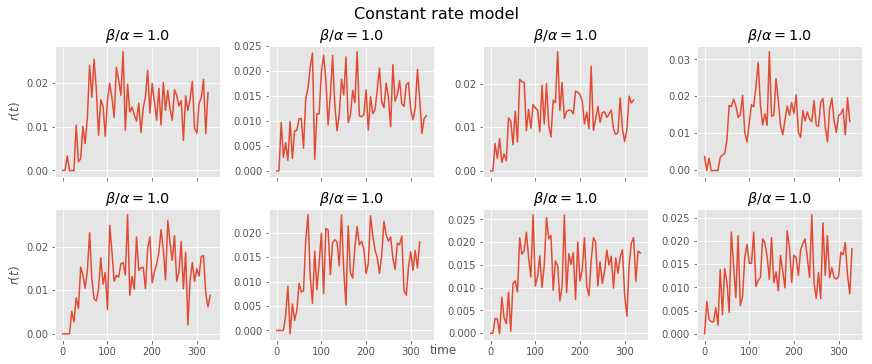

In [94]:
importlib.reload(sims)
k=0
fig,axs = plt.subplots(ncols = 4,nrows=2,figsize=(12,5),sharey=False,sharex=True,constrained_layout=True)
for exp in [e for e in experiments if e != "NoGuideRNA"]:
    
    beta = np.log(2)/60
    model = sims.constant_rate_model(f,f0,beta)


    df = model.run_ensemble(170,200,tmax=500,dt_sample=5)
    
    axs[k%2,k//2].set_title(r"$\beta/\alpha = {:.2}$".format(beta/np.log(2)*60))
    
    
    times = df[df.well==df.well.unique()[0]].time.values
    df = df.groupby(['time']).mean()
    df['time'] = times
    t,r = get_turn_green_rate(df)
    axs[k%2,k//2].plot(t,r,'-')
    

    
    k = k+1
#axs[0].legend(frameon=True)
axs[0,0].set_ylabel(r'$r(t)$')
axs[1,0].set_ylabel(r'$r(t)$')
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.grid(False)

fig.suptitle('Constant rate model', fontsize=16)
plt.xlabel('time');
#plt.ylabel(r'$r(t)$',labelpad =50);
plt.savefig(FIG_PATH+"r-vs-t_constant_rate.pdf",bbox_inches = "tight")

# Broken state model

In [107]:
# define various functions used in simulations
def f(gt,t,n,cell_type):
    if cell_type==1:
        #return np.random.exponential(60) # time to be broken
        return abs(np.random.normal(300,0.3*100))
    else:
        return abs(np.random.normal(60,0.3*60)) # time to double for non-broken cells
    
    
f0 = lambda : np.random.exponential(200) # lag time distribution


In [106]:
importlib.reload(sims)
p = 0.3  # the probability to break
Q = lambda gt,t: np.array([
    [1-p,p,0],
    [0,0,1],
    [0,0,1]
])
types_names = ['m','br','gfp']
model = sims.bellman_harris_model_base(f,f0,Q,types_names)
df = model.run_ensemble(200,1000,tmax=5000,dt_sample=2)

In [110]:
# plt.plot(df_avg.time,df_avg.bf)
# plt.semilogy(df_avg.time,df_avg.gfp)
# plt.semilogy(df_avg.time,df_avg.br)

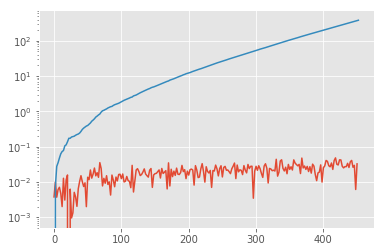

In [104]:


times = df_avg.time.values
bf_avg = df_avg.bf.values
gfp_avg = df_avg.gfp.values
dt = times[1:]-times[:-1]
   
ng = bf_avg[:-1]-gfp_avg[:-1]

dgdt = (gfp_avg[1:]-gfp_avg[:-1])/dt
dndt = (bf_avg[1:]-bf_avg[:-1])/dt


# subtract r2 times green cells per non-green from r1 to get rate to turn green 
r = dgdt-dndt*gfp_avg[:-1]/bf_avg[:-1]
plt.semilogy(times[:-1],r)
plt.semilogy(times,gfp_avg)

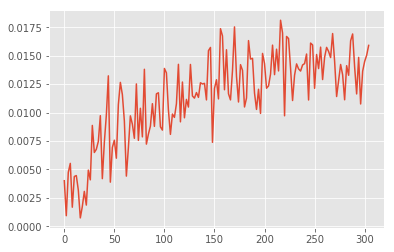

In [105]:
times = df[df.well==df.well.unique()[0]].time.values
df_avg = df.groupby(['time']).mean()
df_avg['time'] = times
t,r = get_turn_green_rate(df_avg)
plt.plot(t,r,'-')

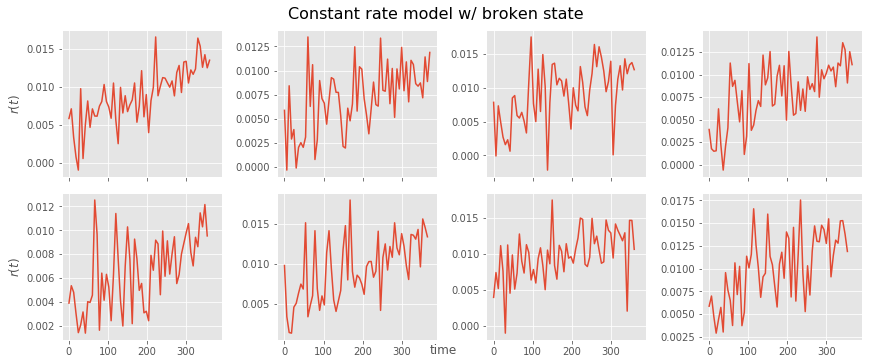

In [109]:
importlib.reload(sims)
k=0
fig,axs = plt.subplots(ncols = 4,nrows=2,figsize=(12,5),sharey=False,sharex=True,constrained_layout=True)
for exp in [e for e in experiments if e != "NoGuideRNA"]:
    
    p = np.random.rand()*0.5 + 0.1  # the probability to break
    Q = lambda gt,t: np.array([
        [1-p,p,0],
        [0,0,1],
        [0,0,1]
    ])
    types_names = ['m','br','gfp']
    model = sims.bellman_harris_model_base(f,f0,Q,types_names)
    df = model.run_ensemble(170,200,tmax=500,dt_sample=6)
    
    #axs[k%2,k//2].set_title(r"$\beta/\alpha = {:.2}$".format(beta/np.log(2)*60))
    
    
    times = df[df.well==df.well.unique()[0]].time.values
    df = df.groupby(['time']).mean()
    df['time'] = times
    t,r = get_turn_green_rate(df)
    axs[k%2,k//2].plot(t,r,'-')
    

    
    k = k+1
#axs[0].legend(frameon=True)
axs[0,0].set_ylabel(r'$r(t)$')
axs[1,0].set_ylabel(r'$r(t)$')
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.grid(False)

fig.suptitle('Constant rate model w/ broken state', fontsize=16)
plt.xlabel('time');
#plt.ylabel(r'$r(t)$',labelpad =50);
plt.savefig(FIG_PATH+"r-vs-t_constant_probability_broken_state.pdf",bbox_inches = "tight")